In [208]:
import os
import geopandas as gp
import shapely
import fiona
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import seaborn as sns
from scipy.stats import chi2_contingency
from shapely.geometry import Point, Polygon, MultiPolygon
from matplotlib.colors import ListedColormap
extract_folder = 'C:\\Users\\oliver\\1161\\dateproject'
zip_file_name = "C:\\Users\\oliver\\1161\\dateproject\\date\\crashdate.zip"

In [209]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

In [211]:
# Check if the target extraction folder exists, create if not
if not os.path.exists(extract_folder):
    os.makedirs(extract_folder)
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)
# Extract contents of the specified ZIP file to the extraction folder
extracted_file_path = os.path.join(extract_folder, 'crashdate.csv')
if os.path.exists(extracted_file_path):
    with open(extracted_file_path, 'r') as file:
# Read the data from the extracted CSV file using pandas        
        penalty_data = pd.read_csv(
            'C:\\Users\\oliver\\1161\\dateproject\\crashdate.csv')
        print("ok")
else:
    print("false")

ok


In [185]:
penalty_data.head(20)

,Crash_Ref_Number,Crash_Severity,Crash_Year,Crash_Month,Crash_Day_Of_Week,Crash_Hour,Crash_Nature,Crash_Type,Crash_Longitude,Crash_Latitude,...,Count_Casualty_MedicallyTreated,Count_Casualty_MinorInjury,Count_Casualty_Total,Count_Unit_Car,Count_Unit_Motorcycle_Moped,Count_Unit_Truck,Count_Unit_Bus,Count_Unit_Bicycle,Count_Unit_Pedestrian,Count_Unit_Other
0,1,Hospitalisation,2001,January,Monday,6,Head-on,Multi-Vehicle,153.052207,-27.586358,...,0,0,1,1,0,0,0,1,0,0
1,2,Property damage only,2001,January,Wednesday,9,Angle,Multi-Vehicle,153.064920,-27.595907,...,0,0,0,2,0,0,0,0,0,0
2,3,Minor injury,2001,January,Thursday,8,Rear-end,Multi-Vehicle,153.058444,-27.599409,...,0,1,1,2,0,0,0,0,0,0
3,4,Property damage only,2001,January,Sunday,8,Hit object,Single Vehicle,153.081083,-27.598882,...,0,0,0,1,0,0,0,0,0,0
4,5,Property damage only,2001,January,Tuesday,16,Overturned,Single Vehicle,0.000009,-0.000010,...,0,0,0,1,0,0,0,0,0,0
5,6,Property damage only,2001,January,Wednesday,9,Angle,Multi-Vehicle,153.015202,-27.566968,...,0,0,0,1,0,1,0,0,0,0
6,7,Property damage only,2001,January,Wednesday,17,Hit object,Single Vehicle,153.060738,-27.587870,...,0,0,0,1,0,0,0,0,0,0
7,8,Medical treatment,2001,January,Thursday,9,Hit pedestrian,Hit pedestrian,153.016442,-27.560409,...,1,0,1,0,0,1,0,0,1,0
8,9,Hospitalisation,2001,January,Sunday,15,Angle,Multi-Vehicle,153.065510,-27.602946,...,0,0,1,1,0,0,0,1,0,0
9,10,Property damage only,2001,January,Tuesday,15,Angle,Multi-Vehicle,153.020787,-27.572325,...,0,0,0,2,0,0,0,0,0,0


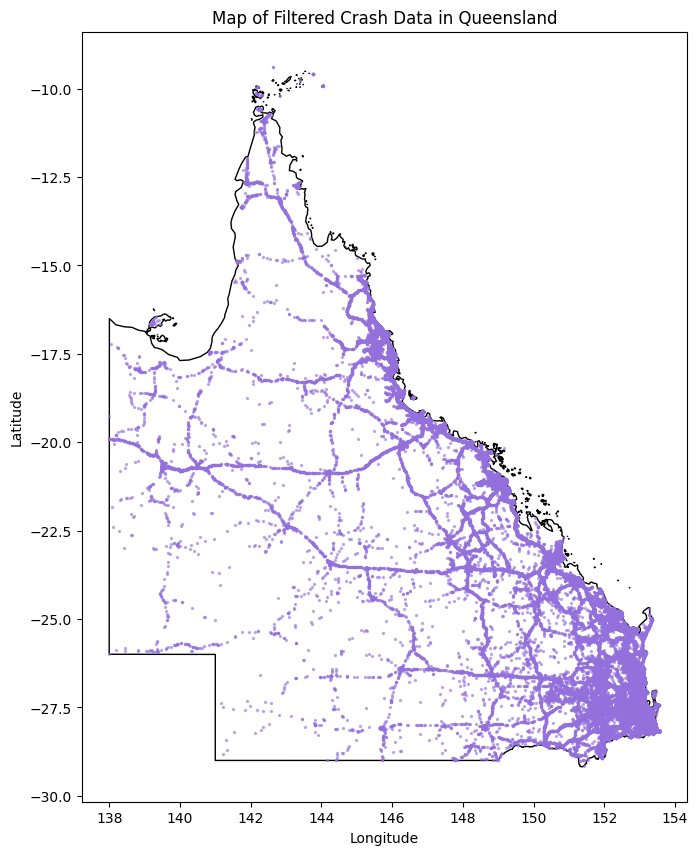

In [212]:
# Define valid ranges for longitude and latitude
valid_longitude_range = (130, 160)
valid_latitude_range = (-30, 0)

# Filter the penalty_data based on valid longitude and latitude ranges
filtered_data = penalty_data[
    (penalty_data['Crash_Longitude'] >= valid_longitude_range[0]) &
    (penalty_data['Crash_Longitude'] <= valid_longitude_range[1]) &
    (penalty_data['Crash_Latitude'] >= valid_latitude_range[0]) &
    (penalty_data['Crash_Latitude'] <= valid_latitude_range[1])
]

# Read the Queensland geospatial data
queensland = gp.read_file(
    'C:\\Users\\oliver\\1161\\dateproject\\date\\queensland.json'
)

# Create a GeoDataFrame with filtered data points
filtered_points = gp.GeoDataFrame(geometry=gp.points_from_xy(
    filtered_data['Crash_Longitude'], filtered_data['Crash_Latitude']
))

# Create a plot showing the Queensland boundary and the filtered data points
fig, axs = plt.subplots(figsize=(20, 10))
queensland.boundary.plot(ax=axs, color='black', linewidth=1)  # Plot Queensland boundary
filtered_points.plot(ax=axs, marker='o', markersize=2,
                     alpha=0.5, color='mediumpurple', zorder=2)  # Plot filtered data points
axs.set_title('Map of Filtered Crash Data in Queensland')
axs.set_xlabel('Longitude')
axs.set_ylabel('Latitude')

# Display the plot
plt.show()


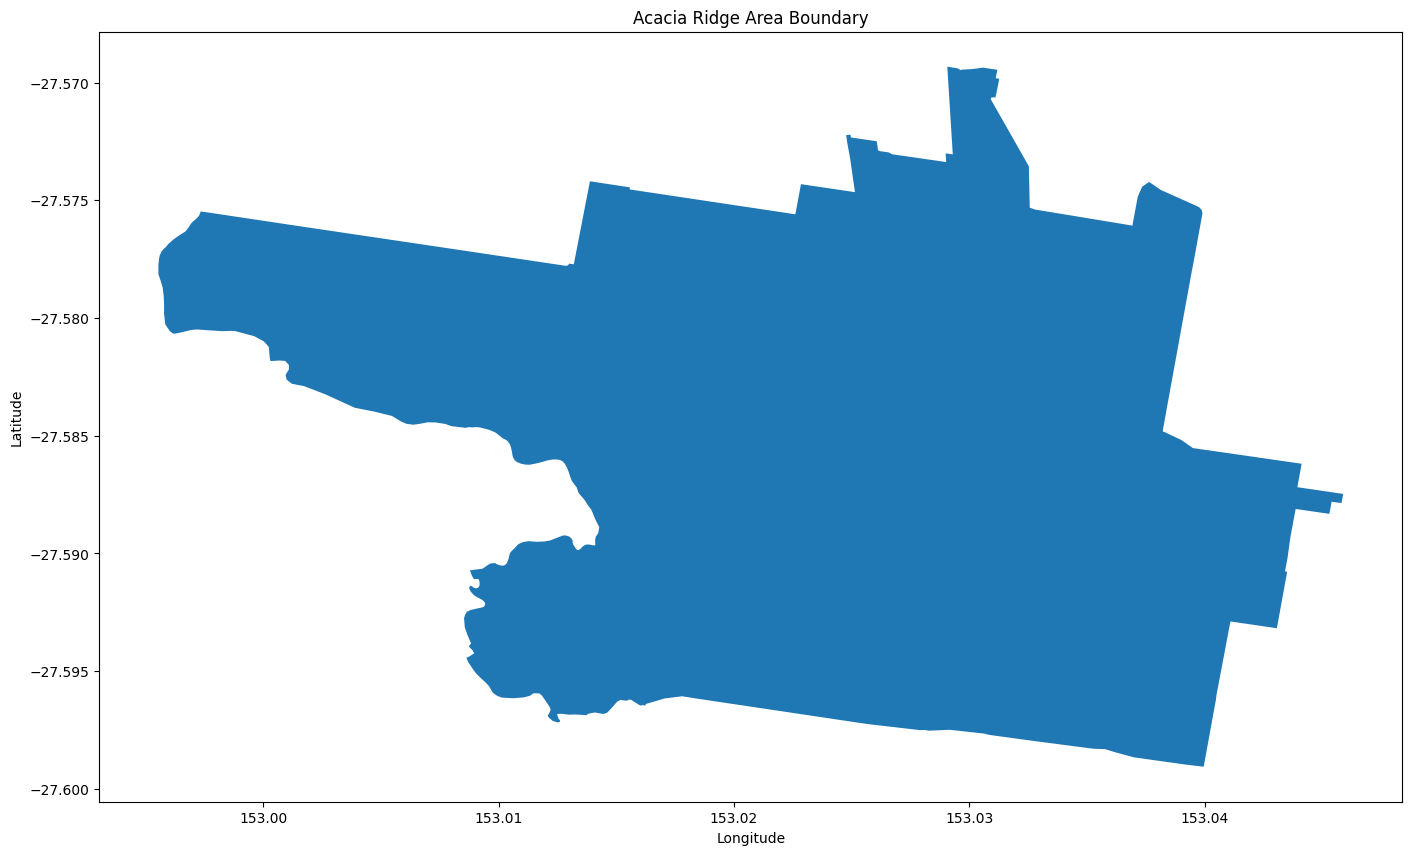

,LC_PLY_PID,LOC_PID,DT_CREATE,LOC_NAME,LOC_CLASS,STATE,geometry
0,lcp1538f231f6a1,locb9e60560b913,2021-06-24,Abbeywood,Gazetted Locality,QLD,"POLYGON ((151.638 -26.146, 151.637 -26.146, 15..."
1,lcp5c0cb0eb8528,locda24ebdbfa94,2021-06-24,Abbotsford,Gazetted Locality,QLD,"POLYGON ((152.004 -24.883, 151.999 -24.879, 15..."
2,lcp1f44628e7c62,loc58529273d380,2021-06-24,Abercorn,Gazetted Locality,QLD,"POLYGON ((151.136 -25.178, 151.135 -25.177, 15..."
3,lcp4bddfa663b0c,loc3c258d5cae53,2021-06-24,Abergowrie,Gazetted Locality,QLD,"POLYGON ((145.998 -18.513, 145.995 -18.513, 14..."
4,lcp191e01d5506a,locf1eb9c4b0e48,2021-06-24,Abingdon Downs,Gazetted Locality,QLD,"POLYGON ((143.763 -18.110, 143.595 -18.094, 14..."
5,lcpec85fef8a167,loc0ca81bdf7282,2021-06-24,Abington,Gazetted Locality,QLD,"POLYGON ((152.370 -25.231, 152.369 -25.231, 15..."
6,lcpeb1b134367c4,loc086288c9d338,2021-06-24,Acacia Ridge,Gazetted Locality,QLD,"POLYGON ((153.040 -27.599, 153.039 -27.599, 15..."
7,lcp2539bc2fa8da,loc8978ca8de825,2021-06-24,Acland,Gazetted Locality,QLD,"POLYGON ((151.711 -27.343, 151.711 -27.343, 15..."
8,lcp0cfd0e921ef4,locd30d7dfae4c2,2021-06-24,Adare,Gazetted Locality,QLD,"POLYGON ((152.311 -27.546, 152.311 -27.545, 15..."
9,lcp6b4328fa372d,loc790fa55d1c0a,2021-12-03,Adavale,Gazetted Locality,QLD,"POLYGON ((144.959 -27.185, 144.867 -27.176, 14..."


In [214]:
# Load the geospatial data for localities from the specified shapefile
burbs = gp.GeoDataFrame.from_file(
    'C:\\Users\\oliver\\1161\\dateproject\\date\\GDA2020\\qld_localities.shp'
)

# Set the Coordinate Reference System (CRS) for the geospatial data
# This ensures that the spatial information is interpreted correctly
# The specified EPSG code (5234) represents GDA2020
burbs.set_crs(epsg=5234, inplace=True, allow_override=True)

# Select the locality data for Acacia Ridge from the loaded geospatial data
gold_coast = burbs[burbs['LOC_NAME'].str.contains('Acacia Ridge', case=False)]

# Plot the selected Acacia Ridge area boundary
gold_coast.plot()

# Set the plot title and labels for the x and y axes
plt.title('Acacia Ridge Area Boundary')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Display the plot
plt.show()

# Display the first 10 rows of the loaded geospatial data (localities)
burbs.head(10)


In [215]:
# Define a function that calculates the centroid of a geometry
def add_centroid(row):
    return row.geometry.centroid

# Apply the "add_centroid" function to each row in the GeoDataFrame "burbs"
# along the specified axis (axis=1 indicates applying the function to rows)
# The result is stored in a new column called "centroid"
burbs["centroid"] = burbs.apply(add_centroid, axis=1)

# Sample two random rows from the GeoDataFrame "burbs"
# This provides a glimpse of the data after adding the "centroid" column
burbs.sample(2)


,LC_PLY_PID,LOC_PID,DT_CREATE,LOC_NAME,LOC_CLASS,STATE,geometry,centroid
2509,lcp9d6123210c07,locd1508aae96d7,2021-06-24,Rubyvale,Gazetted Locality,QLD,"POLYGON ((147.655 -23.489, 147.650 -23.484, 14...",POINT (147.64555 -23.40008)
2326,lcptaEdBJBOKv1N,locc06a131cb3a1,2023-03-21,Pialba,Gazetted Locality,QLD,"POLYGON ((152.847 -25.292, 152.846 -25.292, 15...",POINT (152.83272 -25.27977)


<Axes: >

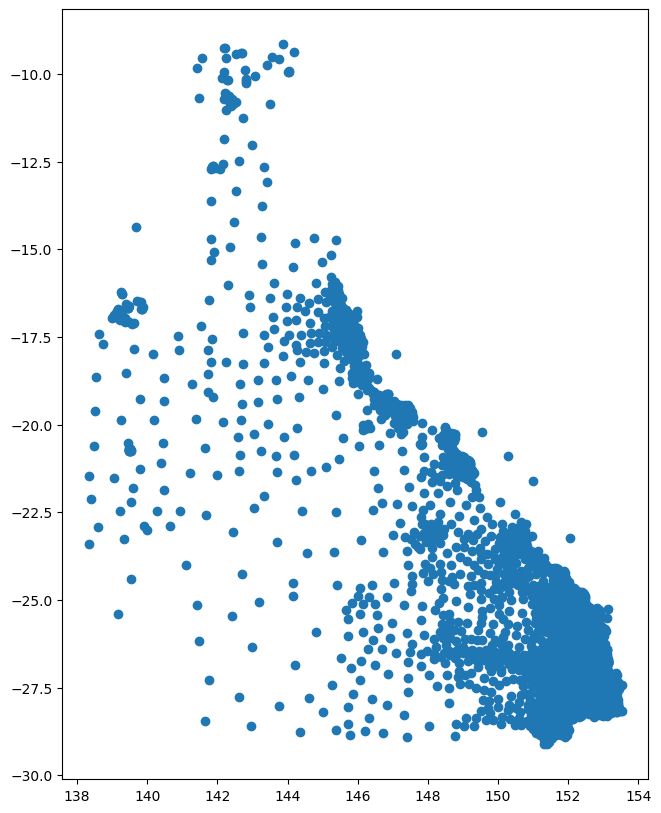

In [216]:
# Plot the centroids of the localities in the GeoDataFrame "burbs"
burbs.centroid.plot()


POINT (152.01080397169943 -24.830328047524123)


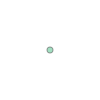

In [222]:
# Extract the geometry (locality polygon) of the second row from the GeoDataFrame "burbs"
a = burbs.iloc[1]

# Calculate and print the centroid of the extracted geometry (locality polygon)
print(a.centroid)

# Plot the extracted geometry (locality polygon) centroid on the map
a.centroid



Text(0.5, 1.0, 'Distribution of distances from The selected center point')

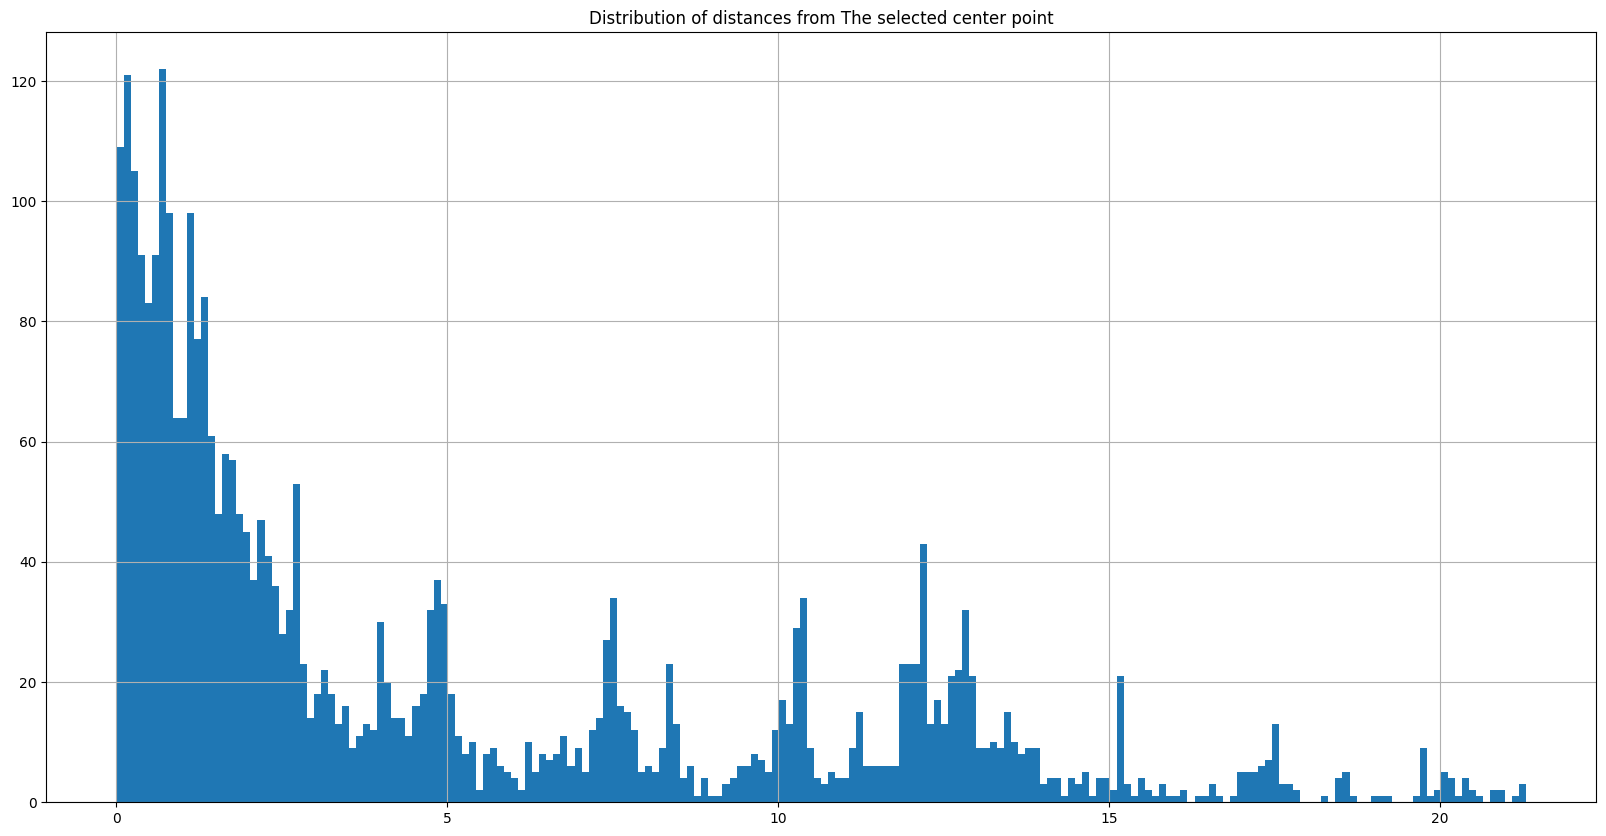

In [225]:
# Create a Shapely Point object representing the coordinates of a location
right_here = shapely.geometry.point.Point(153.0587653330788, -27.478362304023605)

# Calculate the distance from each locality centroid to the specified location (right_here)
# The calculated distances are stored in a new column named "distance_from_UNSW"
burbs["distance_from_The selected center point"] = burbs.centroid.distance(right_here)

# Plot a histogram of the distribution of distances from UNSW for all localities
# The "bins" parameter specifies the number of bins in the histogram
burbs.distance_from_UNSW.hist(bins=200)

# Set the title for the histogram plot
plt.title("Distribution of distances from The selected center point")


<Axes: >

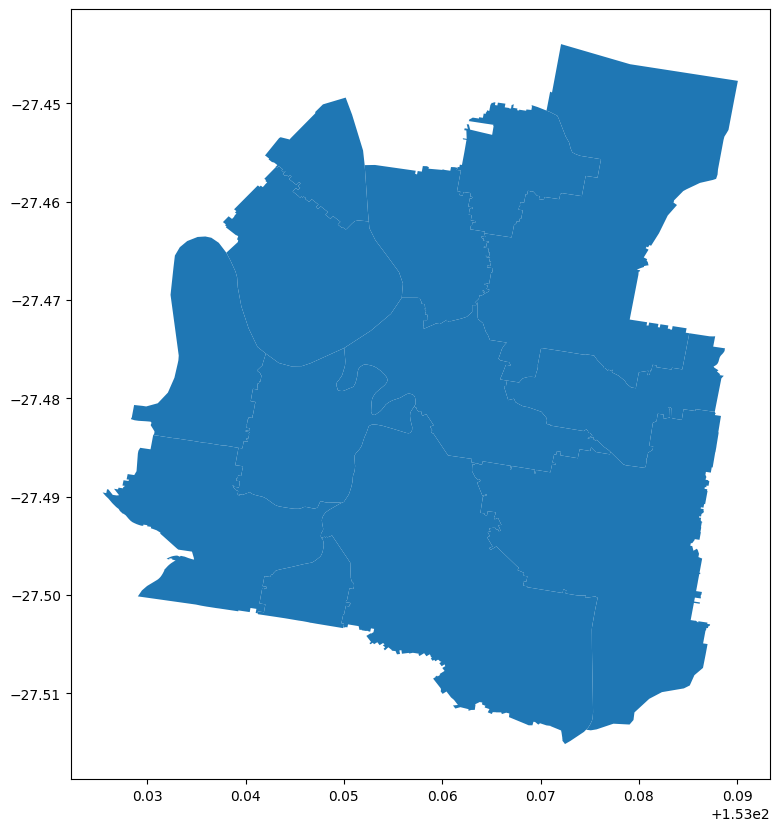

In [226]:
# Select localities from the GeoDataFrame "burbs" that are within a certain distance (less than 0.03) from UNSW
close_burbs = burbs[burbs.distance_from_UNSW < 0.03]

# Plot the selected localities on the map
close_burbs.plot()


In [227]:
points = list(zip(penalty_data['Crash_Longitude'], penalty_data['Crash_Latitude']))
for point in points:
    pass

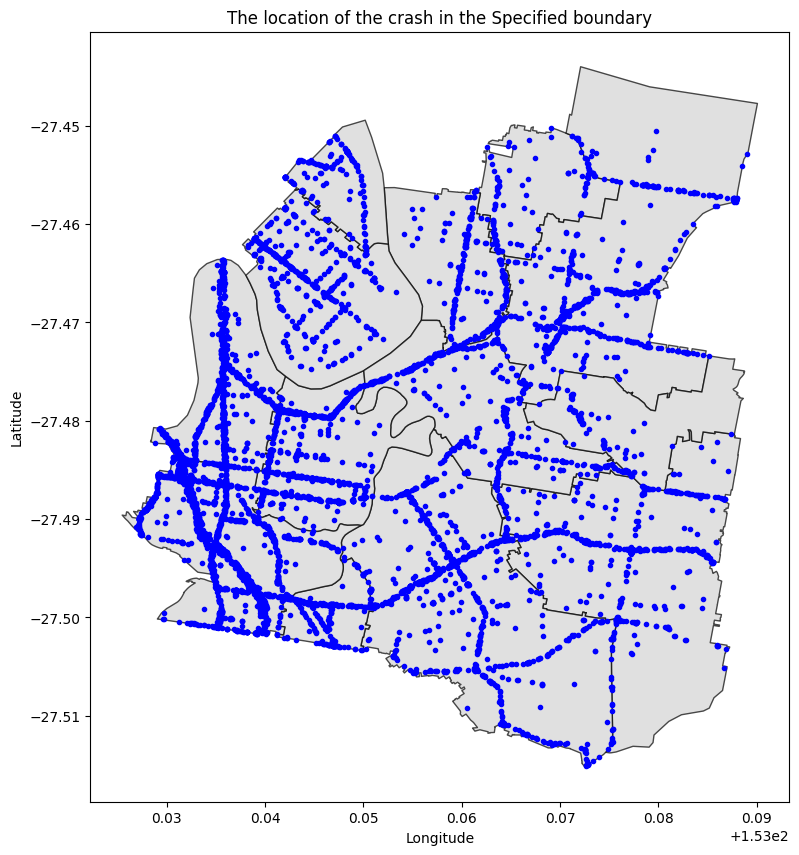

In [231]:
# Create a list of points from the latitude and longitude columns in the penalty_data DataFrame
points = list(zip(penalty_data['Crash_Longitude'], penalty_data['Crash_Latitude']))

# Iterate over each point in the list (currently just a placeholder pass)
for point in points:
    pass

# Create another list of points from the latitude and longitude columns in the penalty_data DataFrame
points = list(zip(penalty_data['Crash_Longitude'], penalty_data['Crash_Latitude']))

# Iterate over each point in the list (currently just a placeholder pass)
for point in points:
    pass

# Specify the column containing geometry information in the close_burbs GeoDataFrame
polygon_column = 'geometry'

# Extract the polygons from the specified geometry column
polygons = close_burbs[polygon_column]

# Convert the list of polygon coordinates to a list of Polygon objects
polygonslist = [Polygon(coords) for coords in polygons]

# Create a MultiPolygon object from the list of Polygon objects
multi_polygon = MultiPolygon(polygonslist)

# Find the points that are inside the MultiPolygon
points_inside_polygons = [
    point for point in points if multi_polygon.contains(Point(point))
]

# Create a plot to visualize the points inside the polygons
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the close_burbs GeoDataFrame as a background
close_burbs.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.7)

# Plot the points inside the polygons in blue
for point in points_inside_polygons:
    plt.plot(point[0], point[1], 'bo', markersize=3)

# Set plot attributes
ax.set_title('The location of the crash in the Specified boundary')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Display the plot
plt.show()



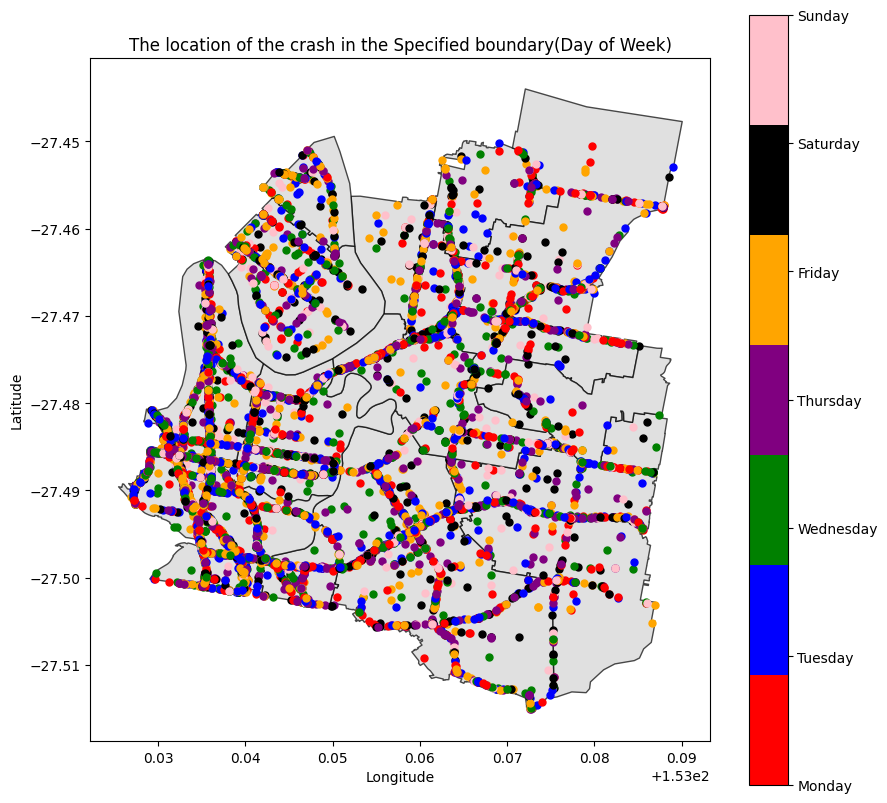

In [232]:
# Extract the 'Crash_Day_Of_Week' column as labels for crash days of the week
crash_day_of_week_labels = penalty_data['Crash_Day_Of_Week']

# Define a mapping from day of the week labels to numeric values
day_of_week_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}

# Map day of the week labels to numeric values
crash_day_of_week_numeric = [day_of_week_mapping[label] for label in crash_day_of_week_labels]

# Define colors for each day of the week
colors = ['red', 'blue', 'green', 'purple', 'orange', 'black', 'pink']

# Create a colormap for the days of the week
cmap = ListedColormap(colors)

# Define a color normalization range
norm = plt.Normalize(vmin=0, vmax=len(day_of_week_mapping) - 1)

# Create a ScalarMappable for the colormap and set it to the current color array
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Specify the column containing geometry information in the close_burbs GeoDataFrame
polygon_column = 'geometry'

# Extract the polygons from the specified geometry column
polygons = close_burbs[polygon_column]

# Convert the list of polygon coordinates to a list of Polygon objects
polygonslist = [Polygon(coords) for coords in polygons]

# Create a MultiPolygon object from the list of Polygon objects
multi_polygon = MultiPolygon(polygonslist)

# Find the points and their corresponding days of the week that are inside the MultiPolygon
points_inside_polygons = [
    (point, day) for point, day in zip(points, crash_day_of_week_numeric) if multi_polygon.contains(Point(point))
]

# Create a plot to visualize the points inside the polygons with day of the week colors
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the close_burbs GeoDataFrame as a background
close_burbs.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.7)

# Plot the points inside the polygons using different colors based on the day of the week
for point, day in points_inside_polygons:
    plt.plot(point[0], point[1], 'o', color=sm.to_rgba(day), markersize=5)

# Create a colorbar to show the mapping between colors and days of the week
cbar = plt.colorbar(sm, ax=ax, ticks=range(len(day_of_week_mapping)))
cbar.set_ticklabels(day_of_week_mapping.keys())

# Set plot attributes
ax.set_title('The location of the crash in the Specified boundary(Day of Week)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Display the plot
plt.show()


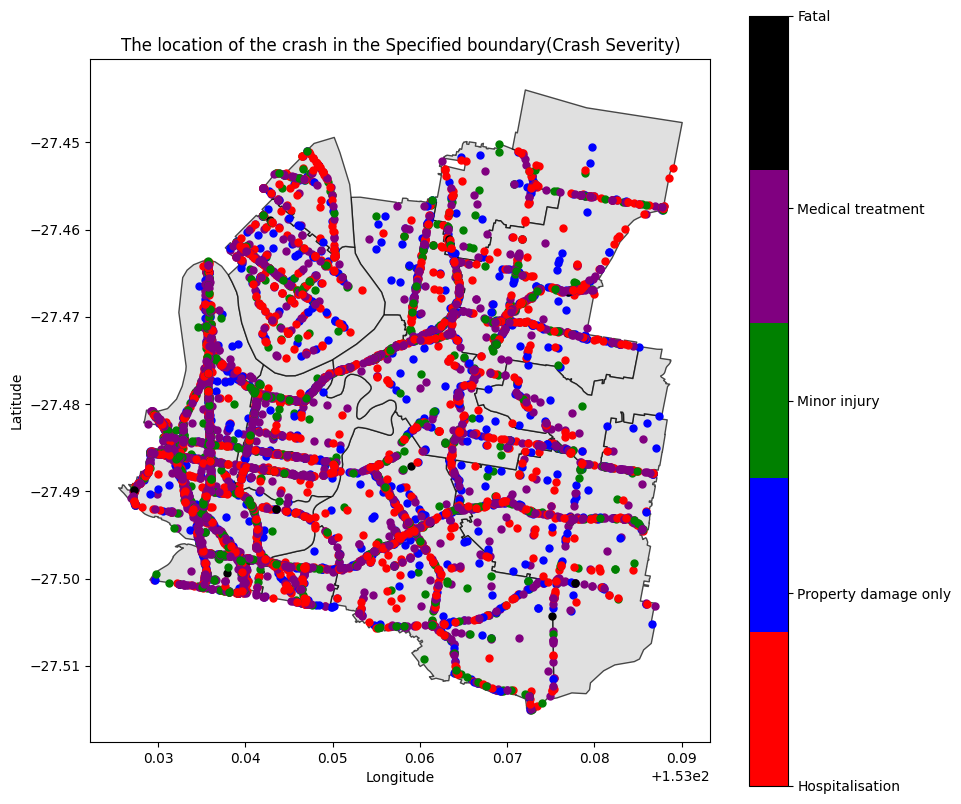

In [233]:
# Extract the 'Crash_Severity' column as labels for crash severity levels
crash_severity_labels = penalty_data['Crash_Severity']

# Define the labels for crash severity levels
severity_labels = ['Hospitalisation', 'Property damage only', 'Minor injury', 'Medical treatment', 'Fatal']

# Create a mapping from crash severity labels to numeric values
severity_mapping = {label: index for index, label in enumerate(severity_labels)}

# Map crash severity labels to numeric values using the defined mapping
crash_severity_numeric = [severity_mapping[label] for label in crash_severity_labels]

# Define colors for each crash severity level
colors = ['red', 'blue', 'green', 'purple', 'black']

# Create a colormap for the crash severity levels
cmap = ListedColormap(colors)

# Define a color normalization range
norm = plt.Normalize(vmin=0, vmax=len(severity_labels) - 1)

# Create a ScalarMappable for the colormap and set it to the current color array
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Specify the column containing geometry information in the close_burbs GeoDataFrame
polygon_column = 'geometry'

# Extract the polygons from the specified geometry column
polygons = close_burbs[polygon_column]

# Convert the list of polygon coordinates to a list of Polygon objects
polygonslist = [Polygon(coords) for coords in polygons]

# Create a MultiPolygon object from the list of Polygon objects
multi_polygon = MultiPolygon(polygonslist)

# Find the points and their corresponding crash severity levels that are inside the MultiPolygon
points_inside_polygons = [
    (point, severity) for point, severity in zip(points, crash_severity_numeric) if multi_polygon.contains(Point(point))
]

# Create a plot to visualize the points inside the polygons with colors representing crash severity levels
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the close_burbs GeoDataFrame as a background
close_burbs.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.7)

# Plot the points inside the polygons using different colors based on crash severity levels
for point, severity in points_inside_polygons:
    plt.plot(point[0], point[1], 'o', color=sm.to_rgba(severity), markersize=5)

# Create a colorbar to show the mapping between colors and crash severity levels
cbar = plt.colorbar(sm, ax=ax, ticks=range(len(severity_labels)))
cbar.set_ticklabels(severity_labels)

# Set plot attributes
ax.set_title('The location of the crash in the Specified boundary(Crash Severity)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Display the plot
plt.show()


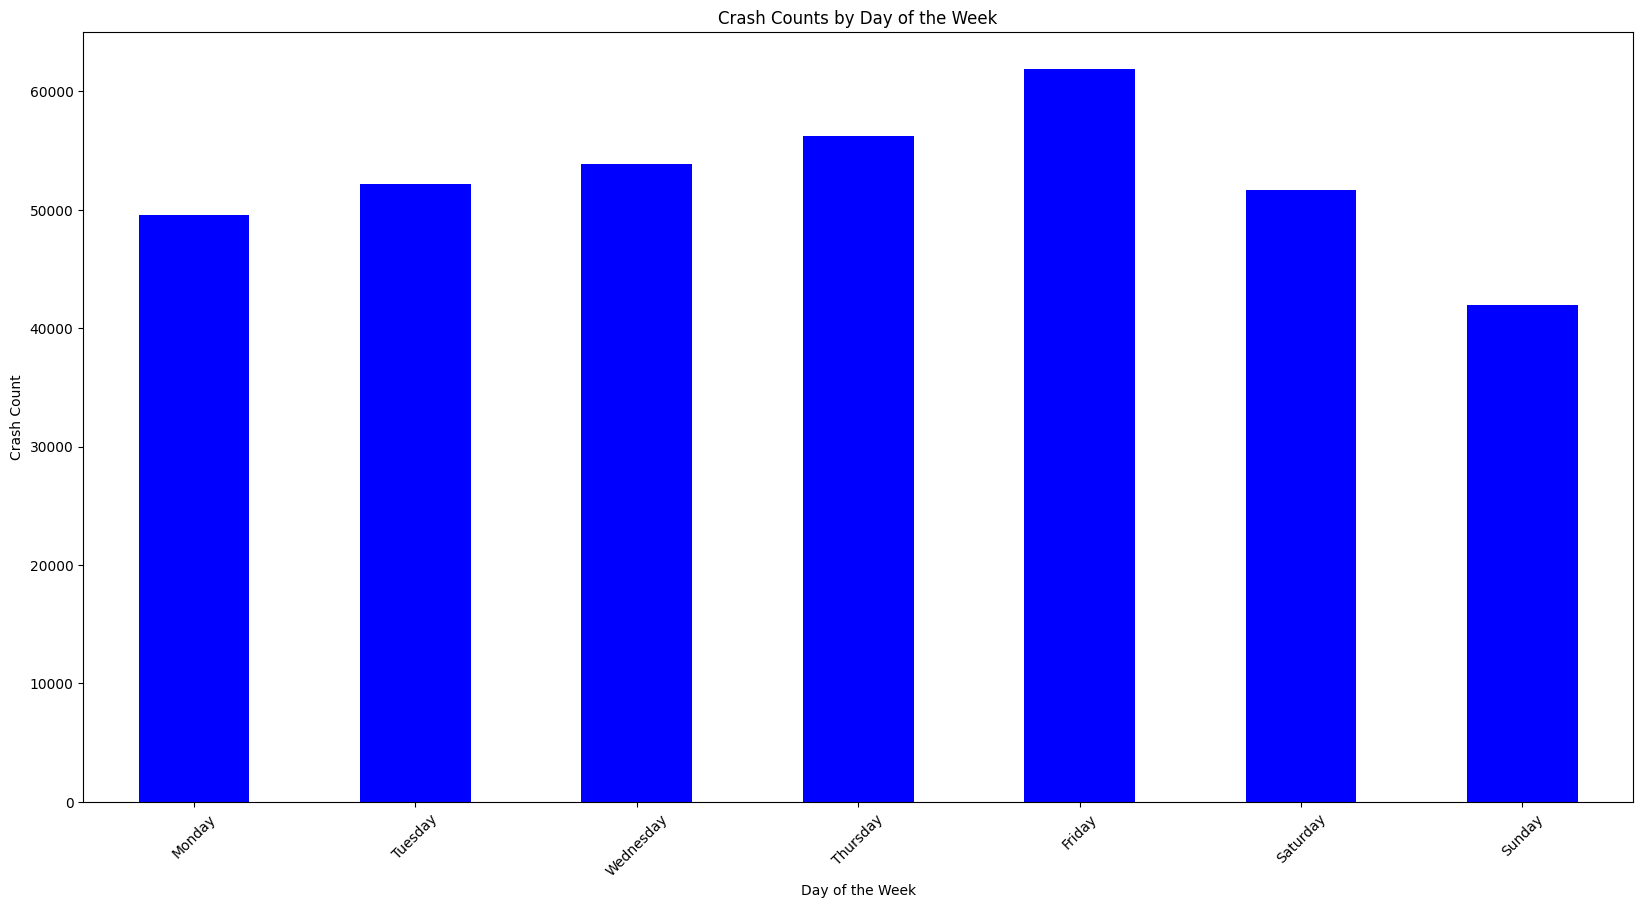

In [234]:
# Convert the "Crash_Day_Of_Week" column to uppercase to ensure consistent casing
data["Crash_Day_Of_Week"] = data["Crash_Day_Of_Week"].str.upper()

# Define a mapping from day names to day numbers
day_mapping = {
    "MONDAY": 1,
    "TUESDAY": 2,
    "WEDNESDAY": 3,
    "THURSDAY": 4,
    "FRIDAY": 5,
    "SATURDAY": 6,
    "SUNDAY": 7
}

# Map day names to day numbers and create a new column "Day_Number" in the DataFrame
data["Day_Number"] = data["Crash_Day_Of_Week"].map(day_mapping)

# Group the data by "Day_Number" and count occurrences for each day
day_counts = data.groupby("Day_Number").size()

# Reindex the day counts to ensure all days of the week are included, even if no data exists for a particular day
day_counts = day_counts.reindex([1, 2, 3, 4, 5, 6, 7], fill_value=0)

# Plot a bar chart to visualize the data counts for each day of the week
day_counts.plot(kind="bar", color="blue")

# Set the x-axis tick labels to display the day names
plt.xticks(range(7), ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation=45)

# Set the title, x-axis label, and y-axis label for the plot
plt.title("Crash Counts by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Crash Count")

# Display the plot
plt.show()


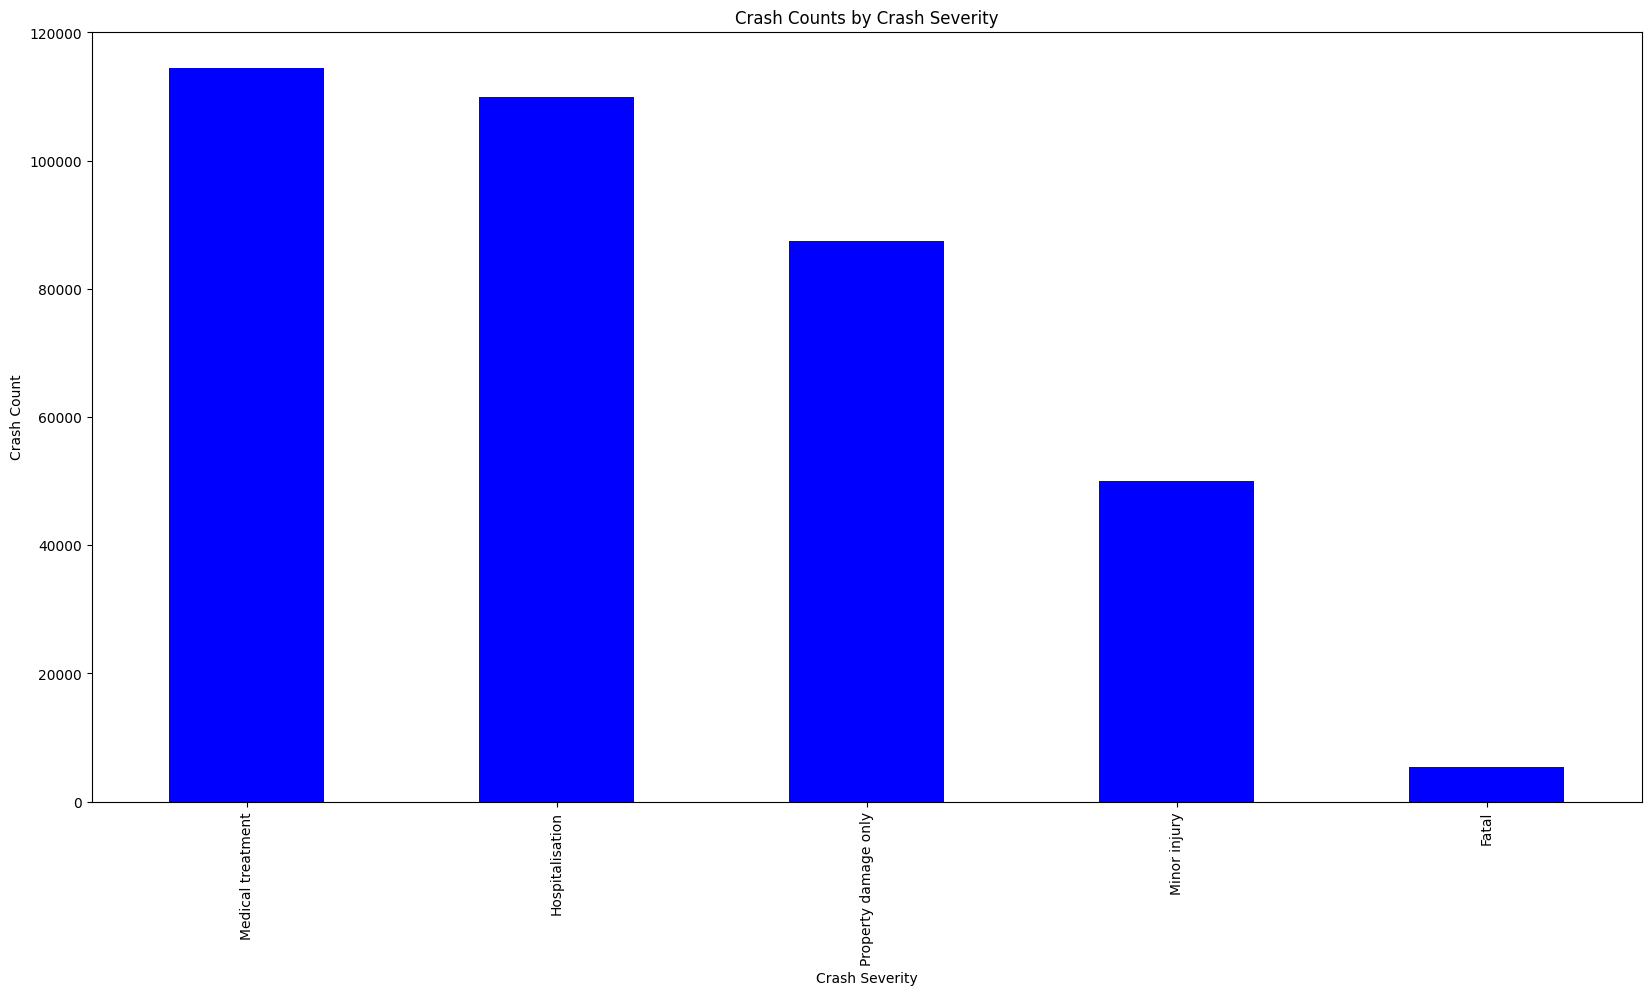

In [236]:
# Define the file path to the CSV file containing the data
file_path = 'C:\\Users\\oliver\\1161\\dateproject\\crashdate.csv'

# Read the data from the CSV file into a DataFrame
data = pd.read_csv(file_path)

# Define a list of crash severity values to filter the data
severity_values = ['Hospitalisation', 'Property damage only', 'Minor injury', 'Medical treatment', 'Fatal']

# Filter the data to include only rows with crash severity values in the defined list
filtered_data = data[data["Crash_Severity"].isin(severity_values)]

# Count the occurrences of each unique crash severity value in the filtered data
severity_counts = filtered_data["Crash_Severity"].value_counts()

# Plot a bar chart to visualize the data counts for each crash severity value
severity_counts.plot(kind='bar', color='blue')

# Set the title, x-axis label, and y-axis label for the plot
plt.title("Crash Counts by Crash Severity")
plt.xlabel("Crash Severity")
plt.ylabel("Crash Count")

# Display the plot
plt.show()


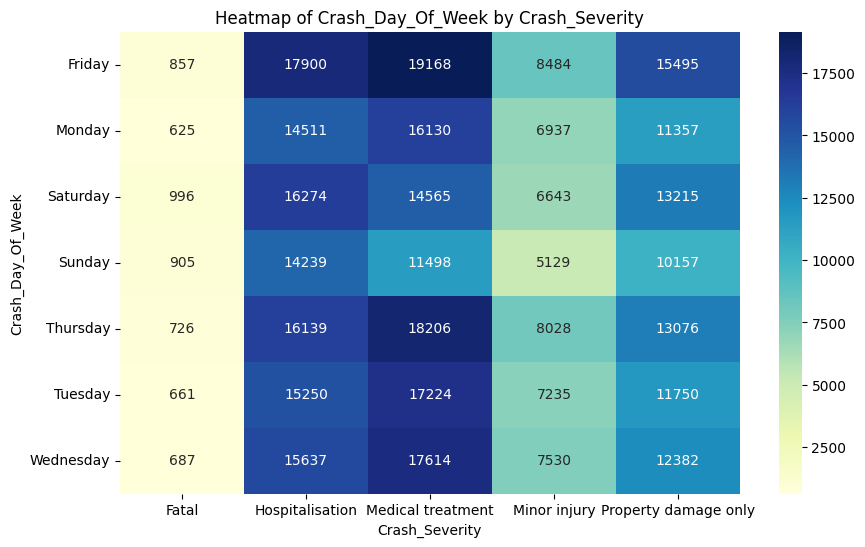

In [201]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency


file_path = 'C:\\Users\\oliver\\1161\\dateproject\\crashdate.csv'
data = pd.read_csv(file_path)


cross_tab = pd.crosstab(data["Crash_Day_Of_Week"], data["Crash_Severity"])


plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap="YlGnBu", fmt='d')
plt.title("Heatmap of Crash_Day_Of_Week by Crash_Severity")
plt.xlabel("Crash_Severity")
plt.ylabel("Crash_Day_Of_Week")
plt.show()


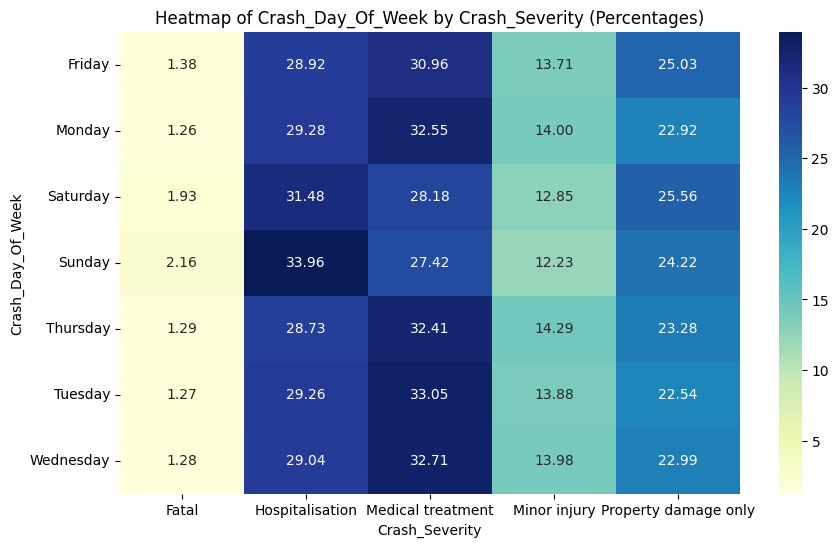

In [241]:
# Define the file path to the CSV file containing the data
file_path = 'C:\\Users\\oliver\\1161\\dateproject\\crashdate.csv'

# Read the data from the CSV file into a DataFrame
data = pd.read_csv(file_path)

# Create a cross-tabulation between Crash_Day_Of_Week and Crash_Severity
cross_tab = pd.crosstab(data["Crash_Day_Of_Week"], data["Crash_Severity"])

# Normalize the crosstab by row (Crash_Day_Of_Week) to get percentages
cross_tab_percent = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

# Create a heatmap of the normalized crosstab (percentages)
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab_percent, annot=True, cmap="YlGnBu", fmt='.2f')
plt.title("Heatmap of Crash_Day_Of_Week by Crash_Severity (Percentages)")
plt.xlabel("Crash_Severity")
plt.ylabel("Crash_Day_Of_Week")
plt.show()


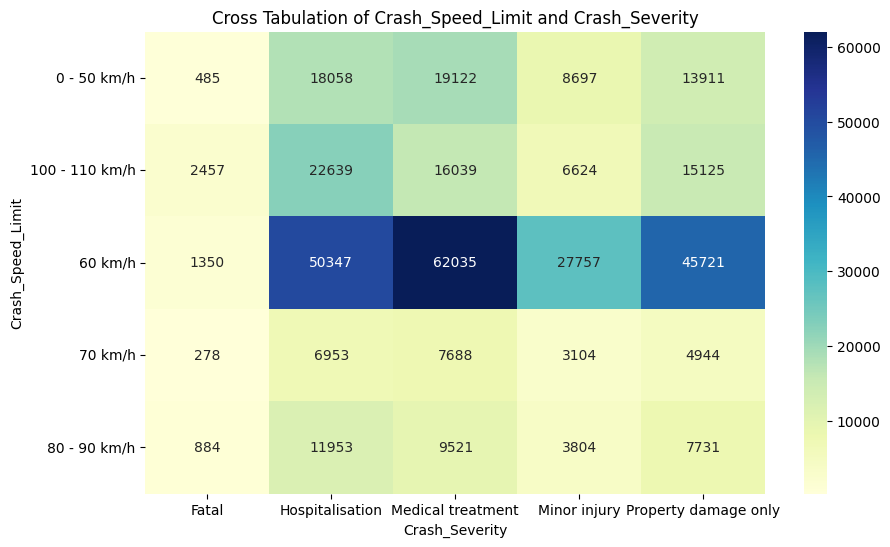

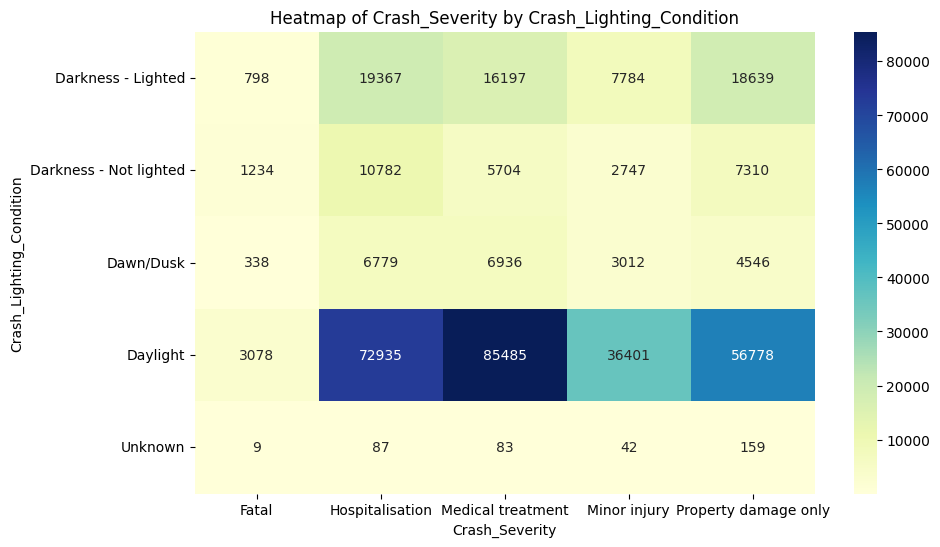

In [203]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data['Crash_Speed_Limit_Encoded'] = encoder.fit_transform(data['Crash_Speed_Limit'])
data['Crash_Severity_Encoded'] = encoder.fit_transform(data['Crash_Severity'])


correlation = data['Crash_Speed_Limit_Encoded'].corr(data['Crash_Severity_Encoded'])


cross_tab = pd.crosstab(data['Crash_Speed_Limit'], data['Crash_Severity'])
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap=sns.color_palette("YlGnBu", n_colors=300), fmt='d')
plt.title("Cross Tabulation of Crash_Speed_Limit and Crash_Severity")
plt.show()


cross_tab = pd.crosstab(data["Crash_Lighting_Condition"], data["Crash_Severity"])

plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap="YlGnBu", fmt='d')
plt.title("Heatmap of Crash_Severity by Crash_Lighting_Condition")
plt.xlabel("Crash_Severity")
plt.ylabel("Crash_Lighting_Condition")
plt.show()





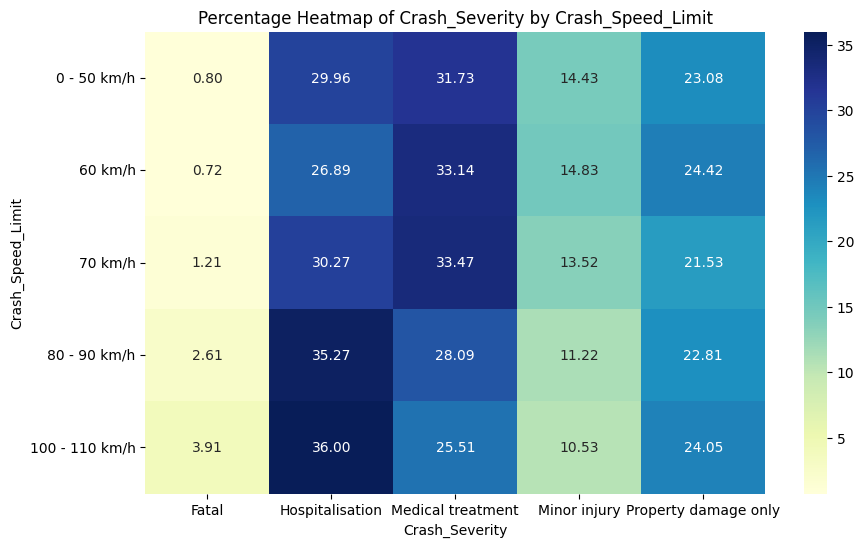

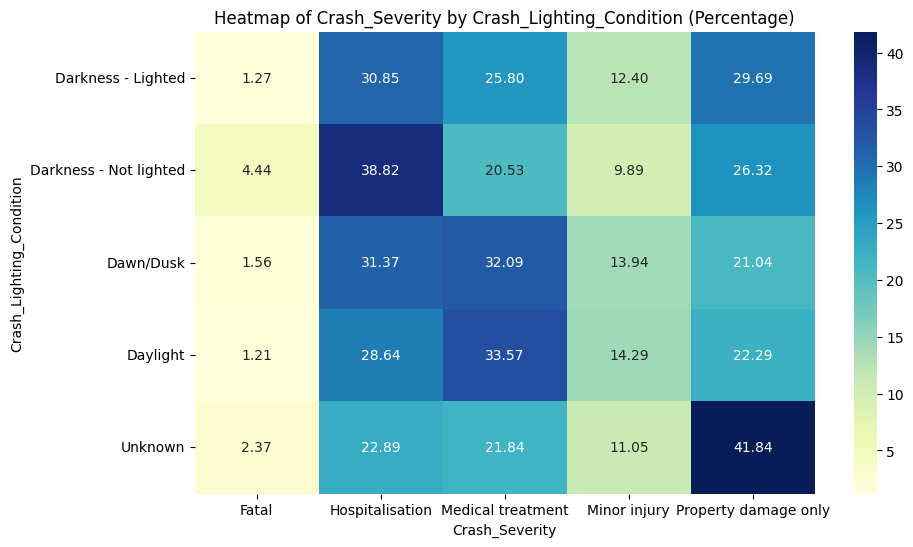

In [204]:

file_path = 'C:\\Users\\oliver\\1161\\dateproject\\crashdate.csv'
data = pd.read_csv(file_path)


speed_limit_order = ["0 - 50 km/h", "60 km/h", "70 km/h", "80 - 90 km/h", "100 - 110 km/h"]
cross_tab = pd.crosstab(data["Crash_Speed_Limit"], data["Crash_Severity"])
cross_tab_reordered = cross_tab.reindex(speed_limit_order)


cross_tab_percentage = cross_tab_reordered.div(cross_tab_reordered.sum(axis=1), axis=0) * 100


plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab_percentage, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Percentage Heatmap of Crash_Severity by Crash_Speed_Limit")
plt.xlabel("Crash_Severity")
plt.ylabel("Crash_Speed_Limit")
plt.show()

cross_tab = pd.crosstab(data["Crash_Lighting_Condition"], data["Crash_Severity"])


cross_tab_percentage = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100


plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab_percentage, annot=True, cmap="YlGnBu", fmt='.2f')
plt.title("Heatmap of Crash_Severity by Crash_Lighting_Condition (Percentage)")
plt.xlabel("Crash_Severity")
plt.ylabel("Crash_Lighting_Condition")
plt.show()




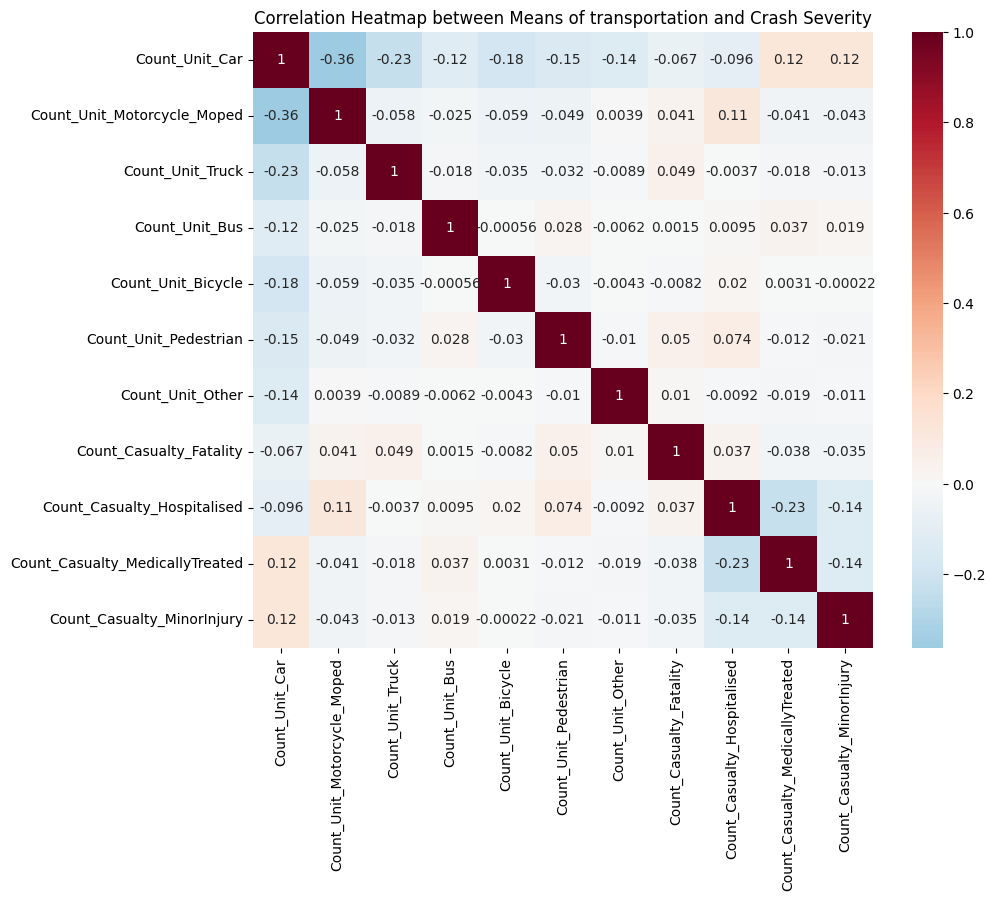

In [239]:
# Define a list of columns of interest related to traffic units and casualty counts
columns_of_interest = [
    "Count_Unit_Car", "Count_Unit_Motorcycle_Moped", "Count_Unit_Truck",
    "Count_Unit_Bus", "Count_Unit_Bicycle", "Count_Unit_Pedestrian",
    "Count_Unit_Other",
    "Count_Casualty_Fatality", "Count_Casualty_Hospitalised",
    "Count_Casualty_MedicallyTreated", "Count_Casualty_MinorInjury"
]

# Subset the data to include only the columns of interest
subset_data = data[columns_of_interest]

# Calculate the correlation matrix between the selected columns
correlation_matrix = subset_data.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="RdBu_r", center=0)

# Set the title for the heatmap
plt.title("Correlation Heatmap between Means of transportation and Crash Severity")

# Display the heatmap
plt.show()